In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_traj, plot_contrast_response, \
                     get_Fano, load_SSSN_variable
from scipy.io import loadmat
import os

In [3]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "./"

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

matfile = loadmat(os.path.join("data", "AgosBiorxiv2.mat"))
W = matfile["W"]
inds = np.arange(W.shape[0])
keep = np.logical_and(W[:,0,0] > 1.2, W[:,3,2] < -.2)
keep_inds = inds[keep]


ind = keep_inds[2]
print('ind', ind)
W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)
x_agos = load_SSSN_variable('rates', ind=ind).numpy()

if ind == 62:
    sigma_eps = np.array([0.00137919, 0.00202632, 0.00074385, 0.00485482])[None,:]
else: 
    sigma_eps = np.array([.00175, .00175, .002, .002])[None,:]
dt = 0.0005
T = 150

ind 62


### 1. Check reconstruction of data from parameter choice.

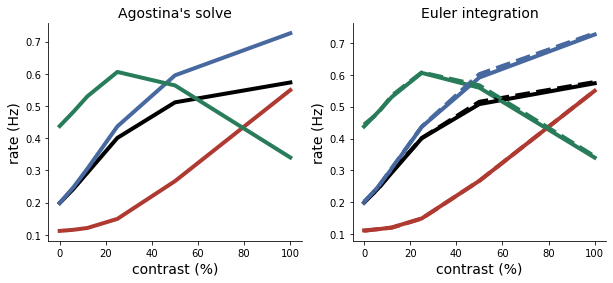

Sum squared errors deterministic 4.9903785e-05
Sum squared errors stochastic 0.00021389461


In [7]:
sssn_sim = SSSN_sim(0., W_mat, dt=dt, T=T)
sssn_sim_stoch = SSSN_sim(0.001, W_mat, N=50, dt=dt, T=T)
sssn_sim_traj = SSSN_sim_traj(np.zeros((1,4)), W_mat, dt=dt, T=T)

c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])

fig, axs = plt.subplots(1,2,figsize=(10,4))
plot_contrast_response(c, x_agos.T, "Agostina's solve", ax=axs[0], colors=colors)

hs = hb[None,:] + c[:,None]*hc[None,:]
x_ss = sssn_sim(hs).numpy()
x_ss_stoch = sssn_sim_stoch(hs).numpy()
plot_contrast_response(c, x_ss[:,0,:], "Euler integration", ax=axs[1], colors=colors)
plot_contrast_response(c, np.mean(x_ss_stoch, axis=1), "Euler integration", ax=axs[1], 
                       colors=colors, linestyle='--')

plt.show()
sse_det = np.sum(np.square(x_agos.T - x_ss[:,0,:4]))
print('Sum squared errors deterministic', sse_det)
sse_stoch = np.sum(np.square(x_agos.T - np.mean(x_ss_stoch[:,:,:4], axis=1)))
print('Sum squared errors stochastic', sse_stoch)

In [8]:
"""high_v = x_ss[:,0,3] > 2000
dh_high_v = dh[high_v]
print(dh_high_v*10)"""

'high_v = x_ss[:,0,3] > 2000\ndh_high_v = dh[high_v]\nprint(dh_high_v*10)'

In [10]:
"""### 2. Get a sense of stability in local input space.
_h = hs = hb[None,:] + 0.5*hc[None,:]
M = 1000
lim = .1
dh = np.random.uniform(-lim, lim, (M,4))
x_ss = sssn_sim_stoch(_h+dh).numpy()
num_nans = np.sum(np.isnan(x_ss))
num_infs = np.sum(np.isinf(x_ss))
print('%d nans and %d infs' % (num_nans, num_infs))
fig, axs = plt.subplots(1,4,figsize=(12,4))
for i in range(4):
    axs[i].hist(x_ss[:,0,i], color=colors[i])
plt.show()

"""

"### 2. Get a sense of stability in local input space.\n_h = hs = hb[None,:] + 0.5*hc[None,:]\nM = 1000\nlim = .1\ndh = np.random.uniform(-lim, lim, (M,4))\nx_ss = sssn_sim_stoch(_h+dh).numpy()\nnum_nans = np.sum(np.isnan(x_ss))\nnum_infs = np.sum(np.isinf(x_ss))\nprint('%d nans and %d infs' % (num_nans, num_infs))\nfig, axs = plt.subplots(1,4,figsize=(12,4))\nfor i in range(4):\n    axs[i].hist(x_ss[:,0,i], color=colors[i])\nplt.show()\n\n"

In [10]:
def get_Fano_slow(sigma_eps, W_mat, N=100, dt=0.0005, T=150, T_ss=100, k=100.):
    sssn_sim_traj = SSSN_sim_traj(sigma_eps, W_mat, N=N, dt=dt, T=T)
    def Fano(h):
        x_t = k*sssn_sim_traj(h)[:,:,:4,T_ss:]
        _means = tf.math.reduce_mean(x_t, axis=3)
        _vars = tf.square(tf.math.reduce_std(x_t, axis=3))
        fano = _vars / _means 
        vars_mean = tf.reduce_mean(fano, axis=1)
        vars_std = tf.math.reduce_std(fano, axis=1)
        T_x = tf.concat((vars_mean, vars_std), axis=1)
        return T_x
    return Fano

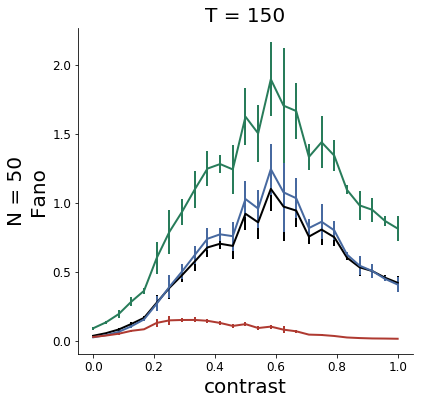

In [12]:
_c = np.linspace(0, 1, 25)

Ns = [50]
Ts = [150]
h_var_means = {}
h_var_stds = {}
_N = 5
for N in Ns:
    for T in Ts:
        Fano = get_Fano_slow(sigma_eps, W_mat, N=N, dt=dt, T=T, T_ss=100, k=100.)
        #Fano = get_Fano(sigma_eps, W_mat, dt=dt, N=N, T=T)
        hs = hb[None,:] + _c[:,None]*hc[None,:]
        h_vars = []
        for k in range(_N):
            print('%2d/%2d \r' % (k+1, _N), end="")
            h_vars.append(Fano(hs).numpy())
        h_vars = np.array(h_vars)
        h_var_means.update({(N,T): np.mean(h_vars, axis=0)})
        h_var_stds.update({(N,T): np.std(h_vars, axis=0)})

fig, axs = plt.subplots(len(Ns), len(Ts), figsize=(6,6))
fontsize= 20
for i, N in enumerate(Ns):
    for j, T in enumerate(Ts):
        if len(Ns) == 1:
            if len(Ts) == 1:
                ax = axs
            else:
                ax = axs[j]
        elif len(Ts) == 1:
            ax = axs[i]
        else:
            ax = axs[i,j]
        h_var_mean = h_var_means[(N,T)]
        h_var_std = h_var_stds[(N,T)]
        for ii in range(4):
            #plt.errorbar(_c, h_var[:,i], h_var[:,i+4], c=colors[i])
            ax.errorbar(_c, h_var_mean[:,ii], h_var_std[:,ii], c=colors[ii])
            #plt.plot(_c, h_var[:,i], c=colors[i])
        if (i==(len(Ns)-1)):
            ax.set_xlabel('contrast', fontsize=fontsize)
        if (j==0):
            ax.set_ylabel('N = %d\nFano' % N, fontsize=fontsize)
        if (i==0):
            ax.set_title('T = %d' % T, fontsize=fontsize)
        #ax.set_ylim([0, 0.05])
plt.show()


In [25]:
print(hc)

tf.Tensor([0.30076382 0.02270158 0.         0.        ], shape=(4,), dtype=float32)


In [26]:
t = dt*np.arange(T+1)
h = hb[None,:] + c[:,None]*hc[None,:]

sssn_sim_traj = SSSN_sim_traj(0.002, W_mat, dt=dt, T=T)
fig, axs = plt.subplots(2,6, figsize=(16, 8))
for jj, alpha in enumerate(['P', 'S']):
    alpha_ind = neuron_inds[alpha]

    delta_step = 0.01
    delta_h = np.zeros((1,4))
    delta_h[0,alpha_ind] = delta_step
    x1_t = sssn_sim_traj(h).numpy()
    x2_t = sssn_sim_traj(h+delta_h).numpy()
    print(x1_t.shape)
    for ii, _c in enumerate(c):
        for j in range(4):
            axs[jj,ii].plot(t, x1_t[ii,0,j,:], c=colors[j])
            axs[jj,ii].plot(t, x2_t[ii,0,j,:], '--', c=colors[j])
        axs[jj,ii].set_ylim([0, 1])
        if ii > 0:
            axs[jj,ii].set_yticklabels([])
    axs[jj,0].set_ylabel('rate (%s-stim)' % alpha)
plt.show()

TypeError: 'float' object is not subscriptable

In [105]:
print(dt)

0.0005


(1, 10, 8, 151)


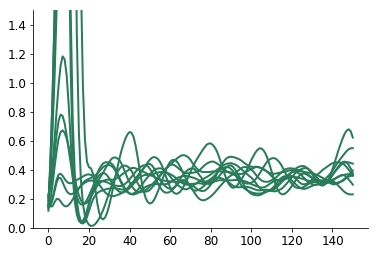

In [106]:
N = 10
T = 150
sssn_sim_traj = SSSN_sim_traj(0.002, W_mat, N=N, dt=dt, T=T)
h = hb[None,:] + 1.*hc[None,:]
x1_t = sssn_sim_traj(h).numpy()
print(x1_t.shape)
plt.figure()
for n in range(N):
    for i in range(4):
        if i==3:
            plt.plot(x1_t[0,n,i,:], c=colors[i])
plt.ylim([0, 1.5])
plt.show()


In [107]:
## Find PE crossings

0 49
P [1.0633931  1.122363   1.1507094  0.95101595 0.3815472  0.9604037 ]
S [ 0.57557523  0.5571693   0.5121842   0.241068   -0.500077   -0.7481098 ]
V [2.710265  3.1730711 3.8003564 5.604732  5.17354   2.5305986]


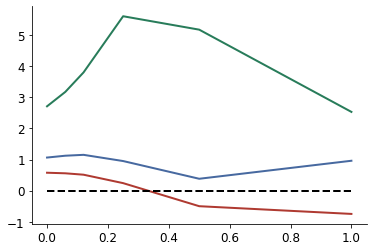

1 57
P [ -3.9766536  -5.423857   -7.378806  -13.443732  -20.400137  -14.098728 ]
S [0.6746769  0.72292536 0.7827759  0.96195936 1.3290286  2.6291788 ]
V [1.526624  1.5659213 1.6102552 1.713562  1.7715216 2.273327 ]


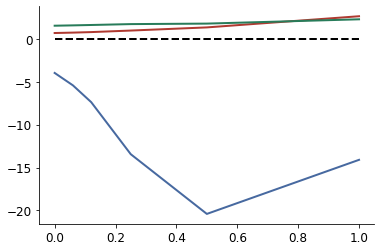

2 62
P [ -2.83525   -4.452245  -6.625632 -11.763251 -14.609492 -12.465048]
S [0.719215   0.69815147 0.6504506  0.43768436 0.27471483 0.45825243]
V [ 1.3944864  1.3432562  1.2096345  0.7270396  0.394392  -0.0543803]


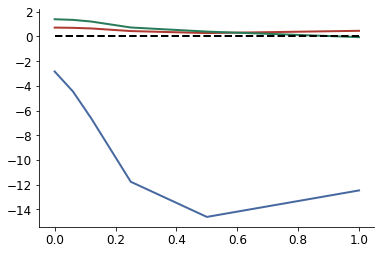

3 72
P [ -1.6570345  -2.612582   -3.9647162  -8.285999  -12.698514   -9.613622 ]
S [0.70885867 0.70602596 0.69288015 0.5846411  0.3685087  0.69978833]
V [1.7089546  1.841253   2.0148516  2.4827123  2.0380735  0.95401406]


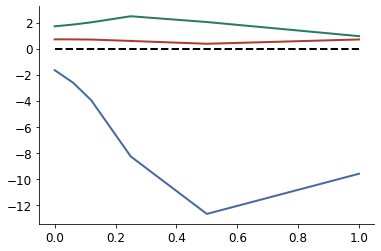

4 75
P [ 0.80666244  0.7861376   0.7110596   0.2083242  -0.95099807 -0.37270188]
S [ 0.7608488   0.7666066   0.75639784  0.6025225  -0.08342862 -0.38708448]
V [2.4734974 2.8046548 3.2405019 4.529476  4.7102156 2.055356 ]


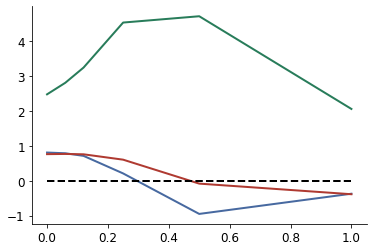

5 111
P [ -2.0138547  -3.0174017  -4.457015   -9.536922  -16.023035  -11.468744 ]
S [0.6299615  0.65694004 0.68812966 0.7956177  1.3436288  1.9634962 ]
V [1.6713262 1.7095208 1.7450452 1.7457843 1.4991343 1.2385696]


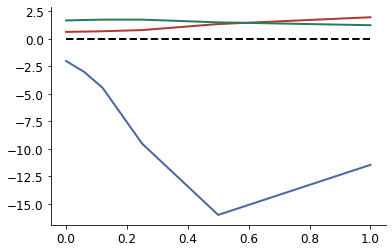

6 128
P [-0.4257381  -0.77795684 -1.2265027  -2.3464322  -2.1893442   1.5498757 ]
S [0.727582   0.7531434  0.76700747 0.7245302  0.5647421  0.99264383]
V [2.4424136 2.696973  3.0174851 3.9053798 4.867995  3.9780111]


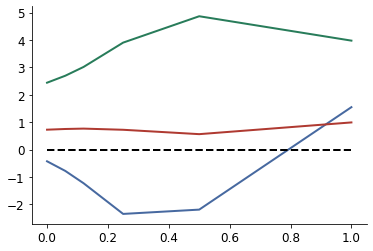

7 176
P [ 0.26622117  0.08526444 -0.1876831  -1.1077464  -1.976496    0.735265  ]
S [ 0.7901192   0.7848576   0.75864196  0.5666137  -0.02582371 -0.16976595]
V [2.7273178 3.0300617 3.4094572 4.332173  4.087436  4.446635 ]


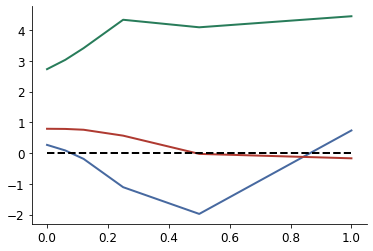

8 186
P [ 0.49995482  0.3718257   0.18133521 -0.28639436 -0.5779505  -7.4356914 ]
S [ 0.3656909   0.30918717  0.22933483  0.01989007 -0.21615922 -1.334393  ]
V [2.3141801 2.6628077 3.0072927 3.390026  2.8733373 3.5304606]


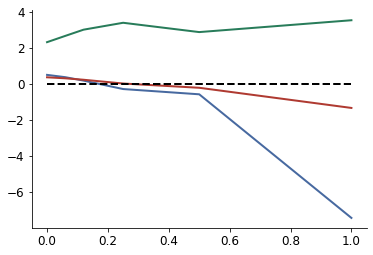

9 191
P [ 0.7096827   0.75291395  0.79640746  0.8979112  -2.1020055   0.7463604 ]
S [ 0.42468756  0.39186776  0.35046935  0.2443865  -5.989766   -1.0872811 ]
V [2.3985028 2.771765  3.1936884 4.0872636 0.8828521 0.6982297]


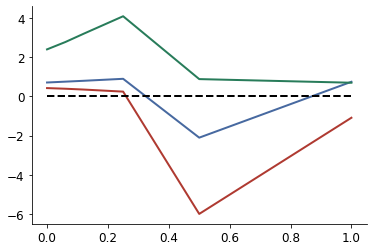

In [11]:
from epi.SSSN import get_drdh
c = np.array([0., 0.06, 0.12, 0.25, 0.5, 1.])
inhib_types = ['P', 'S', 'V']
for i in range(10):
    ind = keep_inds[i]
    print(i, ind)
    W_mat = load_SSSN_variable('W', ind=ind)
    hb = load_SSSN_variable('hb', ind=ind)
    hc = load_SSSN_variable('hc', ind=ind)
    h = hb[None,:] + c[:,None]*hc[None,:]
    
    drdhs = []
    for alpha in inhib_types:
        drdh = get_drdh(alpha, 0.0, W_mat, N=1, delta_step=0.01)
        T_x = drdh(h)
        print(alpha, T_x[:,0].numpy())
        drdhs.append(T_x[:,0])
        
    drdhs = np.array(drdhs)
    plt.figure()
    for j, alpha in enumerate(inhib_types):
        plt.plot(c, drdhs[j], c=colors[neuron_inds[alpha]])
    plt.plot([c[0], c[-1]], [0,0], 'k--')
    plt.show()

In [14]:
"""ind = keep_inds[_is[0]]
W_mat = load_SSSN_variable('W', ind=ind)
hb = load_SSSN_variable('hb', ind=ind)
hc = load_SSSN_variable('hc', ind=ind)

c_pe = []
for alpha in ['P', 'S']:
    drdh = get_drdh(alpha, 0.0, W_mat, 1, 0.01)
    c_min = 0.
    c_max = 1.
    for i in range(25):
        _c = (c_min + c_max)/2.
        h = hb[None,:] + _c*hc[None,:]
        T_x = drdh(h)
        _drdh = T_x[:,0].numpy()
        if _drdh > 0.:
            c_min = _c
        elif _drdh < 0.:
            c_max = _c
        else:
            break
        print(i, _c, _drdh)
    c_pe.append(_c)
print(c_pe)"""

0 0.5 [-14.200166]
1 0.25 [-11.763287]
2 0.125 [-6.8277597]
3 0.0625 [-4.532018]
4 0.03125 [-3.6074028]
5 0.015625 [-3.2029958]
6 0.0078125 [-3.01466]
7 0.00390625 [-2.9238448]
8 0.001953125 [-2.879268]
9 0.0009765625 [-2.8571784]
10 0.00048828125 [-2.8461964]
11 0.000244140625 [-2.8407307]
12 0.0001220703125 [-2.8379755]


KeyboardInterrupt: 